In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
dataWithAttack = pd.read_csv("C:\\Users\\Gökhan\\Desktop\\nids-adversarial\\data\\with_attack_cat_clear_data.csv", low_memory=False)

In [4]:
TARGET = 'attack_cat'

In [5]:
print(f"Using target column: {TARGET} (unique classes: {dataWithAttack[TARGET].nunique()})")
dataWithAttack[TARGET] = dataWithAttack[TARGET].astype(str)  # ensure consistent dtype

Using target column: attack_cat (unique classes: 14)


In [6]:
total = len(dataWithAttack)
vc = dataWithAttack[TARGET].value_counts(dropna=False)
vc_pct = (vc / total * 100).round(3)
summary = pd.DataFrame({'count': vc, 'percent': vc_pct})
print(f"Total rows: {total}\nUnique classes: {dataWithAttack[TARGET].nunique()}\n")
display(summary)

Total rows: 2540026
Unique classes: 14



,count,percent
attack_cat,,
Normal,2218743,87.351
Generic,215481,8.483
Exploits,44525,1.753
Fuzzers,19195,0.756
DoS,16353,0.644
Reconnaissance,12228,0.481
Fuzzers,5051,0.199
Analysis,2677,0.105
Backdoor,1795,0.071


In [7]:
def clean_attack_column(dataWithAttack, column_name='attack_cat'):
    replacement_map = {
        'backdoors': 'backdoor',
        'fuzzers ': 'fuzzers',  # olası boşluk hatası
        'dos ': 'dos',
        'shellcode ': 'shellcode',
    }

    dataWithAttack = dataWithAttack.copy()  # orijinali bozmamak için kopya
    dataWithAttack[column_name] = (
        dataWithAttack[column_name]
          .astype('string')
          .str.strip()
          .str.lower()
          .replace(replacement_map)
          .str.capitalize()
    )
    return dataWithAttack

In [8]:
dataWithAttack = clean_attack_column(dataWithAttack, 'attack_cat')

In [9]:
if TARGET in dataWithAttack.columns:
    total = len(dataWithAttack)
    vc = dataWithAttack[TARGET].value_counts(dropna=False)
    vc_pct = (vc / total * 100).round(3)
    summary = pd.DataFrame({'count': vc, 'percent': vc_pct})
    print(f"Total rows: {total}\nUnique classes: {dataWithAttack[TARGET].nunique()}\n")
    display(summary)

Total rows: 2540026
Unique classes: 10



,count,percent
attack_cat,,
Normal,2218743,87.351
Generic,215481,8.483
Exploits,44525,1.753
Fuzzers,24246,0.955
Dos,16353,0.644
Reconnaissance,13987,0.551
Analysis,2677,0.105
Backdoor,2329,0.092
Shellcode,1511,0.059


In [10]:
# 1) Prepare features and target
X = dataWithAttack.drop(columns=[TARGET])
y = dataWithAttack[TARGET]

In [11]:
# 2) Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [12]:
# 3) Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded  # ensure balanced split
)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2032020, 61), (508006, 61), (2032020,), (508006,))

In [13]:
# TRAIN
dataWithAttack.loc[X_train.index, "attack_cat"].value_counts()
dataWithAttack.loc[X_train.index, "attack_cat"].value_counts(normalize=True).mul(100)

attack_cat
Normal            87.351207
Generic             8.48343
Exploits           1.752936
Fuzzers            0.954567
Dos                0.643793
Reconnaissance     0.550634
Analysis           0.105412
Backdoor           0.091682
Shellcode          0.059497
Worms               0.00684
Name: proportion, dtype: Float64

In [32]:
# TRAIN
dataWithAttack.loc[X_test.index, "attack_cat"].value_counts()
dataWithAttack.loc[X_test.index, "attack_cat"].value_counts(normalize=True).mul(100)

attack_cat
Normal            87.351134
Generic            8.483364
Exploits           1.752932
Fuzzers            0.954516
Dos                 0.64389
Reconnaissance     0.550781
Analysis           0.105314
Backdoor           0.091731
Shellcode          0.059448
Worms               0.00689
Name: proportion, dtype: Float64

In [15]:
# 2) Kolon tiplerini belirleyelim
# Sayısal/kategorik ayrımı: object ve category -> kategorik; geri kalan -> sayısal varsayımı
def split_columns(X_train, target):
    cols = [c for c in X_train.columns if c != target]
    cat_cols = []
    num_cols = []

    for c in cols:
        if X_train[c].dtype.name in ["object", "category"]:
            cat_cols.append(c)
        else:
            # Çok-unique ve sayısal görünümlü object'ler varsa dönüştürmeyi düşünebilirsiniz.
            num_cols.append(c)

    return num_cols, cat_cols

num_cols, cat_cols = split_columns(X_train, TARGET)
print("Numeric:", len(num_cols), "\nCategorical:", len(cat_cols))


Numeric: 40 
Categorical: 3


In [16]:
dataWithAttack.head(10)

,sport,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,33661,1024,udp,CON,0.036133,528,304,31,29,0,...,0,2,4,2,3,1,1,2,Normal,0
1,1464,53,udp,CON,0.001119,146,178,31,29,0,...,0,12,8,1,2,2,1,1,Normal,0
2,3593,53,udp,CON,0.001209,132,164,31,29,0,...,0,6,9,1,1,1,1,1,Normal,0
3,49664,53,udp,CON,0.001169,146,178,31,29,0,...,0,7,9,1,1,1,1,1,Normal,0
4,32119,111,udp,CON,0.078339,568,312,31,29,0,...,0,2,4,2,3,1,1,2,Normal,0
5,2142,53,udp,CON,0.001134,132,164,31,29,0,...,0,12,7,1,2,2,1,1,Normal,0
6,0,0,arp,INT,0.000000,46,0,0,0,0,...,0,2,2,2,2,2,2,2,Normal,0
7,40726,53,udp,CON,0.001126,146,178,31,29,0,...,0,6,7,3,1,1,1,1,Normal,0
8,12660,53,udp,CON,0.001167,132,164,31,29,0,...,0,6,7,2,1,1,1,1,Normal,0
9,0,0,arp,INT,0.000000,46,0,0,0,0,...,0,2,2,2,2,2,2,2,Normal,0


In [17]:
dataWithAttack = dataWithAttack.drop(columns=['Label'])

In [18]:
dataWithAttack.head(10)

,sport,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,...,ct_state_ttl,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat
0,33661,1024,udp,CON,0.036133,528,304,31,29,0,...,0,0,2,4,2,3,1,1,2,Normal
1,1464,53,udp,CON,0.001119,146,178,31,29,0,...,0,0,12,8,1,2,2,1,1,Normal
2,3593,53,udp,CON,0.001209,132,164,31,29,0,...,0,0,6,9,1,1,1,1,1,Normal
3,49664,53,udp,CON,0.001169,146,178,31,29,0,...,0,0,7,9,1,1,1,1,1,Normal
4,32119,111,udp,CON,0.078339,568,312,31,29,0,...,0,0,2,4,2,3,1,1,2,Normal
5,2142,53,udp,CON,0.001134,132,164,31,29,0,...,0,0,12,7,1,2,2,1,1,Normal
6,0,0,arp,INT,0.000000,46,0,0,0,0,...,2,0,2,2,2,2,2,2,2,Normal
7,40726,53,udp,CON,0.001126,146,178,31,29,0,...,0,0,6,7,3,1,1,1,1,Normal
8,12660,53,udp,CON,0.001167,132,164,31,29,0,...,0,0,6,7,2,1,1,1,1,Normal
9,0,0,arp,INT,0.000000,46,0,0,0,0,...,2,0,2,2,2,2,2,2,2,Normal


In [19]:
print("Categorical features:", cat_cols)

Categorical features: ['proto', 'state', 'ct_ftp_cmd']


In [20]:
# Counting the unique values of the categorical features...

for col_name in X_train.columns:
    if X_train[col_name].dtypes == 'object':
        unique_cat = len(X_train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique values.".format(col_name = col_name, unique_cat = unique_cat))

Feature 'proto' has 134 unique values.
Feature 'state' has 15 unique values.
Feature 'ct_ftp_cmd' has 9 unique values.


In [21]:
def normalize_col(s: pd.Series):
    return s.astype(str).str.lower().str.strip().fillna("unknown")

def pick_top_categories(s: pd.Series, k=6):
    return normalize_col(s).value_counts().head(k).index.tolist()

def add_binary_flags(df: pd.DataFrame, col: str, keep: list, add_other=True, drop_original=True):
    s = normalize_col(df[col])
    for cat in keep:
        new_col = f"is_{col}_{cat}"
        df[new_col] = (s == cat).astype("uint8")
    if add_other:
        df[f"is_{col}_other"] = (~s.isin(keep)).astype("uint8")
    if drop_original:
        df.drop(columns=[col], inplace=True)
    return df

In [22]:
top_proto = pick_top_categories(X_train['proto'], k=6)

X_train = add_binary_flags(X_train, 'proto', top_proto, add_other=True, drop_original=True)
X_test  = add_binary_flags(X_test,  'proto', top_proto, add_other=True, drop_original=True)

In [23]:
top_state = pick_top_categories(X_train['state'], k = 6)

X_train = add_binary_flags(X_train, 'state', top_state, add_other=True, drop_original=True)
X_test  = add_binary_flags(X_test,  'state', top_state, add_other=True, drop_original=True)

In [24]:
top_ct = pick_top_categories(X_train['ct_ftp_cmd'], k = 6)

X_train = add_binary_flags(X_train, 'ct_ftp_cmd', top_ct, add_other=True, drop_original=True)
X_test  = add_binary_flags(X_test,  'ct_ftp_cmd', top_ct, add_other=True, drop_original=True)

In [25]:
# 4) Train RandomForest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

In [26]:
print("Training RandomForest...")
rf.fit(X_train, y_train)

Training RandomForest...


,n_estimators,200
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
# Train seti üzerinde tahminler
print("=== Train Set Performance ===")
y_pred_train = rf.predict(X_train)

# Etiketleri orijinal formata çevir
y_train_orig = le.inverse_transform(y_train)
y_pred_train_orig = le.inverse_transform(y_pred_train)

# Metrikleri hesapla ve göster
train_acc = accuracy_score(y_train_orig, y_pred_train_orig)
train_f1 = f1_score(y_train_orig, y_pred_train_orig, average='macro')

print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Train F1-macro: {train_f1:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_train_orig, y_pred_train_orig))

=== Train Set Performance ===

Train Accuracy: 0.9874
Train F1-macro: 0.7333

Detailed Classification Report:
                precision    recall  f1-score   support

      Analysis       0.19      0.35      0.25      2142
      Backdoor       0.12      0.55      0.19      1863
           Dos       0.43      0.74      0.55     13082
      Exploits       0.97      0.60      0.74     35620
       Fuzzers       0.99      0.89      0.94     19397
       Generic       1.00      0.99      0.99    172385
        Normal       1.00      1.00      1.00   1774994
Reconnaissance       0.91      0.85      0.88     11189
     Shellcode       0.85      1.00      0.92      1209
         Worms       0.77      1.00      0.87       139

      accuracy                           0.99   2032020
     macro avg       0.72      0.80      0.73   2032020
  weighted avg       0.99      0.99      0.99   2032020



Bu tablo önemli

Normal            87.351134
Generic            8.483364
Exploits           1.752932
Fuzzers            0.954516
Dos                 0.64389
Reconnaissance     0.550781
Analysis           0.105314
Backdoor           0.091731
Shellcode          0.059448
Worms               0.00689

            precision    recall  f1-score   support

      Analysis       0.19      0.35      0.25      2142
      Backdoor       0.12      0.55      0.19      1863
           Dos       0.43      0.74      0.55     13082
      Exploits       0.97      0.60      0.74     35620
       Fuzzers       0.99      0.89      0.94     19397
       Generic       1.00      0.99      0.99    172385
        Normal       1.00      1.00      1.00   1774994
Reconnaissance       0.91      0.85      0.88     11189
     Shellcode       0.85      1.00      0.92      1209
         Worms       0.77      1.00      0.87       139

      accuracy                           0.99   2032020
     macro avg       0.72      0.80      0.73   2032020
  weighted avg       0.99      0.99      0.99   2032020

In [28]:
# --- Test seti ile değerlendirme ---
# rf, X_test, y_test, le değişkenleri zaten notebook'ta tanımlı olmalı
y_pred_test = rf.predict(X_test)

# Orijinal string etiketlere dönüştür
y_test_orig = le.inverse_transform(y_test)
y_pred_test_orig = le.inverse_transform(y_pred_test)

print("=== Test Set Performance ===")
test_acc = accuracy_score(y_test_orig, y_pred_test_orig)
test_f1 = f1_score(y_test_orig, y_pred_test_orig, average='macro')
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test F1-macro: {test_f1:.4f}\n")

print("Detailed Classification Report:")
print(classification_report(y_test_orig, y_pred_test_orig, zero_division=0))

=== Test Set Performance ===

Test Accuracy: 0.9841
Test F1-macro: 0.6585

Detailed Classification Report:
                precision    recall  f1-score   support

      Analysis       0.13      0.28      0.18       535
      Backdoor       0.03      0.12      0.04       466
           Dos       0.33      0.51      0.40      3271
      Exploits       0.85      0.57      0.68      8905
       Fuzzers       0.97      0.88      0.92      4849
       Generic       1.00      0.98      0.99     43096
        Normal       1.00      1.00      1.00    443749
Reconnaissance       0.85      0.81      0.83      2798
     Shellcode       0.72      0.96      0.83       302
         Worms       0.73      0.69      0.71        35

      accuracy                           0.98    508006
     macro avg       0.66      0.68      0.66    508006
  weighted avg       0.99      0.98      0.99    508006



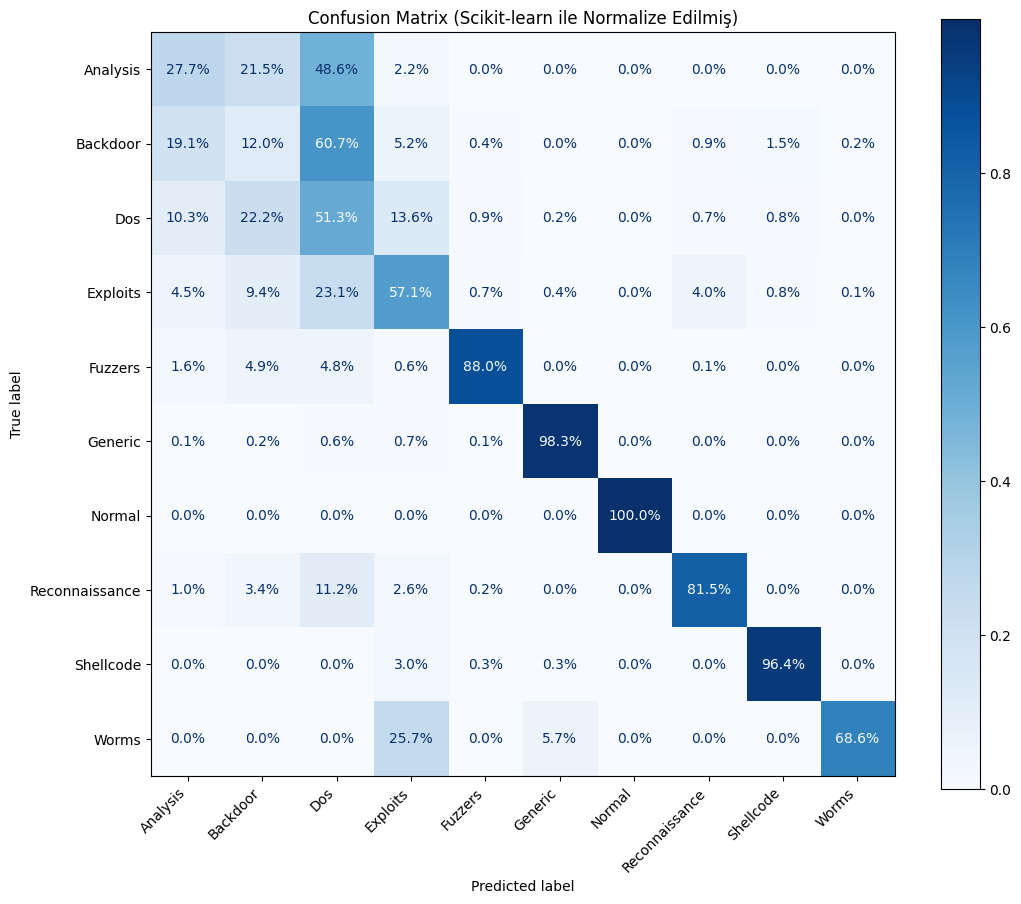

In [29]:
# Sınıf isimlerini alalım
class_names = le.classes_

# Grafik boyutunu ayarlayalım
fig, ax = plt.subplots(figsize=(12, 10))

# Scikit-learn'ün çizim fonksiyonunu kullanıyoruz
# normalize='true' -> Satır bazlı yüzde (Recall) hesaplar
# values_format='.1%' -> %98.5 formatında yazar
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_orig, 
    y_pred_test_orig,
    display_labels=class_names,
    normalize='true', 
    cmap=plt.cm.Blues,
    values_format='.1%',
    ax=ax
)

# Başlık ve Eksen Ayarları
disp.ax_.set_title("Confusion Matrix (Scikit-learn ile Normalize Edilmiş)")
plt.xticks(rotation=45, ha="right") # Yazıları eğik yap
plt.show()

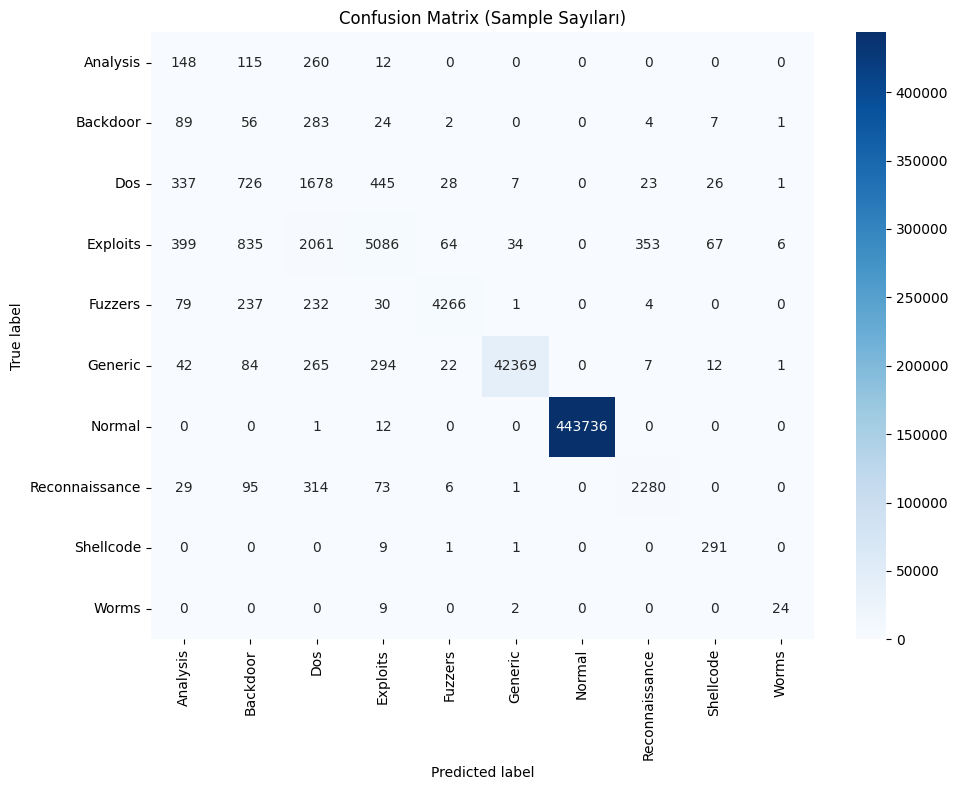

In [42]:
cm = confusion_matrix(y_test_orig, y_pred_test_orig)   # normalize yok!

class_names = ["Analysis", "Backdoor", "Dos", "Exploits",
               "Fuzzers", "Generic", "Normal", 
               "Reconnaissance", "Shellcode", "Worms"]

plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            annot=True,        # hücrelerin içine yaz
            fmt='d',           # 'd' = integer (sample sayısı)
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix (Sample Sayıları)')
plt.tight_layout()
plt.show()

Bunun aynısı ama sample sayıları yazsın

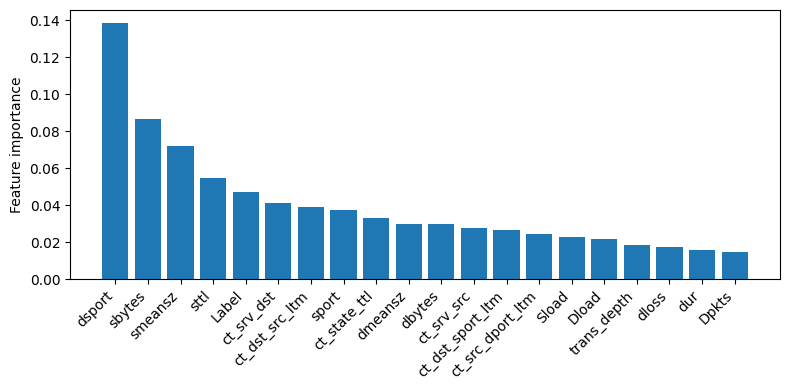

In [43]:
importances = rf.feature_importances_
feature_names = np.array(X_test.columns)

# Önem skorlarını büyükten küçüğe sırala
indices = np.argsort(importances)[::-1]

# Kaç tanesini göstermek istiyorsun?
top_k = 20

plt.figure(figsize=(8, 4))
plt.bar(range(top_k), importances[indices][:top_k])

plt.xticks(
    range(top_k),
    feature_names[indices][:top_k],
    rotation=45,          # 45 derecelik eğim
    ha="right"            # sağa hizala, çakışmasın
)

plt.ylabel("Feature importance")
plt.tight_layout()
plt.show()

In [44]:
print("len(importances) =", len(importances))
print("len(feature_names) =", len(feature_names))


len(importances) = 61
len(feature_names) = 61
